In [223]:
# Utils
import torch
import torchvision.transforms as trans
from scipy.ndimage import map_coordinates
torch.pi = torch.acos(torch.zeros(1)).item() * 2

In [263]:
import numpy as np

def rotation_matrix(rad, ax):
    ax = np.array(ax)
    assert len(ax.shape) == 1 and ax.shape[0] == 3
    ax = ax / np.sqrt((ax**2).sum())
    R = np.diag([np.cos(rad)] * 3)
    R = R + np.outer(ax, ax) * (1.0 - np.cos(rad))
    ax = ax * np.sin(rad)
    R = R + np.array([[0, -ax[2], ax[1]],
                      [ax[2], 0, -ax[0]],
                      [-ax[1], ax[0], 0]])

    return R

def xyzpers(h_fov, v_fov, u, v, out_hw, in_rot):
    out = np.ones((*out_hw, 3), np.float32)
    x_max = np.tan(h_fov / 2)
    y_max = np.tan(v_fov / 2)
    x_rng = np.linspace(-x_max, x_max, num=out_hw[1], dtype=np.float32)
    y_rng = np.linspace(-y_max, y_max, num=out_hw[0], dtype=np.float32)
    out[..., :2] = np.stack(np.meshgrid(x_rng, -y_rng), -1)
    Rx = rotation_matrix(v, [1, 0, 0])
    Ry = rotation_matrix(u, [0, 1, 0])
    dots = np.array([0, 0, 1.0]).dot(Rx).dot(Ry)
    Ri = rotation_matrix(in_rot, dots)
    return out.dot(Rx).dot(Ry).dot(Ri)



def xyz2uv(xyz):
    '''
    xyz: ndarray in shape of [..., 3]
    '''
    x, y, z = np.split(xyz, 3, axis=-1)
    u = np.arctan2(x, z)
    c = np.sqrt(x**2 + z**2)
    v = np.arctan2(y, c)

    return np.concatenate([u, v], axis=-1)




def uv2unitxyz(uv):
    u, v = np.split(uv, 2, axis=-1)
    y = np.sin(v)
    c = np.cos(v)
    x = c * np.sin(u)
    z = c * np.cos(u)

    return np.concatenate([x, y, z], axis=-1)

def uv2coor(uv, h, w):
    '''
    uv: ndarray in shape of [..., 2]
    h: int, height of the equirectangular image
    w: int, width of the equirectangular image
    '''
    u, v = np.split(uv, 2, axis=-1)
    coor_x = (u / (2 * np.pi) + 0.5) * w - 0.5
    coor_y = (-v / np.pi + 0.5) * h - 0.5

    return np.concatenate([coor_x, coor_y], axis=-1)

def coor2uv(coorxy, h, w):
    coor_x, coor_y = np.split(coorxy, 2, axis=-1)
    u = ((coor_x + 0.5) / w - 0.5) * 2 * np.pi
    v = -((coor_y + 0.5) / h - 0.5) * np.pi

    return np.concatenate([u, v], axis=-1)

def sample_equirec(e_img, coor_xy, order):
    w = e_img.shape[1]
    coor_x, coor_y = np.split(coor_xy, 2, axis=-1)
    pad_u = np.roll(e_img[[0]], w // 2, 1)
    pad_d = np.roll(e_img[[-1]], w // 2, 1)
    e_img = np.concatenate([e_img, pad_d, pad_u], 0)
    return map_coordinates(e_img, [coor_y, coor_x],
                           order=order, mode='wrap')[..., 0]

def e2p(e_img, h_fov, v_fov, u_deg, v_deg, out_hw, in_rot_deg=0, mode='bilinear'):
    '''
    e_img:   ndarray in shape of [H, W, *]
    h_fov,v_fov: scalar or (scalar, scalar) field of view in degree
    u_deg:   horizon viewing angle in range [-180, 180]
    v_deg:   vertical viewing angle in range [-90, 90]
    '''
    assert len(e_img.shape) == 3
    h, w = e_img.shape[:2]

    try:
        h_fov, v_fov = h_fov * np.pi / 180, v_fov * np.pi / 180
    except:
        h_fov, v_fov = fov, fov
    in_rot = in_rot_deg * np.pi / 180

    if mode == 'bilinear':
        order = 1
    elif mode == 'nearest':
        order = 0
    else:
        raise NotImplementedError('unknown mode')

    u = -u_deg * np.pi / 180
    v = v_deg * np.pi / 180
    xyz = xyzpers(h_fov, v_fov, u, v, out_hw, in_rot)
    uv = xyz2uv(xyz)
    coor_xy = uv2coor(uv, h, w)

    pers_img = np.stack([
        sample_equirec(e_img[..., i], coor_xy, order=order)
        for i in range(e_img.shape[2])
    ], axis=-1)

    return pers_img,coor_xy[...,::-1]

##############################################################################################################################

def Te2p(e_img, h_fov, v_fov, u_deg, v_deg, out_hw, in_rot_deg=torch.tensor([0.]), mode='bilinear'):
    '''
    e_img:   ndarray in shape of [H, W, *]
    h_fov,v_fov: scalar or (scalar, scalar) field of view in degree
    u_deg:   horizon viewing angle in range [-180, 180]
    v_deg:   vertical viewing angle in range [-90, 90]
    '''
    b, c, h, w = e_img.shape
    
    h_fov, v_fov = h_fov * torch.pi / 180., v_fov * torch.pi / 180.
    
    in_rot = in_rot_deg * torch.pi / 180.
    
    if mode == 'bilinear':
        order = 1
    elif mode == 'nearest':
        order = 0
    else:
        raise NotImplementedError('unknown mode')

    u = -u_deg * torch.pi / 180.
    v = v_deg * torch.pi / 180.
    xyz = Txyzpers(h_fov, v_fov, u, v, out_hw, in_rot)
    uv = Txyz2uv(xyz)
    coor_xy = Tuv2coor(uv, torch.tensor([h], dtype = float), torch.tensor([w], dtype = float))
    mid = torch.tensor([w/2.,h/2.]).reshape(1,1,2)
    cords = (coor_xy-mid)/mid
    pers_img = torch.nn.functional.grid_sample(input=e_img, grid = cords.unsqueeze(0).float(), align_corners=True, mode = mode)
    return pers_img,uv
    

def Tuv2coor(uv, h, w):
    '''
    uv: ndarray in shape of [..., 2]
    h: int, height of the equirectangular image
    w: int, width of the equirectangular image
    '''
    u, v = torch.split(uv, 1, -1)
    coor_x = (u / (2 * torch.pi) + 0.5) * w - 0.5
    coor_y = (-v / torch.pi + 0.5) * h - 0.5
    return torch.cat([coor_x, coor_y], -1)

def Tcoor2uv(coorxy, h, w):
    coor_x, coor_y = torch.split(coorxy, 1, -1)
    u = ((coor_x + 0.5) / w - 0.5) * 2 * torch.pi
    v = -((coor_y + 0.5) / h - 0.5) * torch.pi
    return torch.cat([u, v], -1)


def Tuv2unitxyz(uv):
    u, v = torch.split(uv, 1, -1)
    y = torch.sin(v)
    c = torch.cos(v)
    x = c * np.sin(u)
    z = c * np.cos(u)

    return torch.cat([x, y, z], dim=-1)

def Txyz2uv(xyz):
    '''
    xyz: ndarray in shape of [..., 3]
    '''
    x, y, z = torch.split(xyz, 1, -1)
    u = torch.atan2(x, z)
    c = torch.sqrt(x**2 + z**2)
    v = torch.atan2(y, c)

    return torch.cat([u, v], -1)




def Trotation_matrix(rad, ax):
    """
    rad : torch.tensor, Eg. torch.tensor([2.0])
    ax  : torch.tensor, Eg. [1,0,0] or [0,1,0] or [0,0,1]
    """
    ax = ax / torch.pow(ax,2).sum()
    R = torch.diag(torch.cat([torch.cos(rad)]*3))
    R = R + torch.outer(ax, ax) * (1.0 - torch.cos(rad))
    ax = ax * torch.sin(rad)
    R = R + torch.tensor([[0, -ax[2], ax[1]],
                          [ax[2], 0, -ax[0]],
                          [-ax[1], ax[0], 0]], dtype = ax.dtype)
    return R

def Txyzpers(h_fov, v_fov, u, v, out_hw, in_rot):
    out = torch.ones((*out_hw, 3), dtype=float)
    
    x_max = torch.tan(torch.tensor([h_fov / 2])).item()
    y_max = torch.tan(torch.tensor([v_fov / 2])).item()
    x_rng = torch.linspace(-x_max, x_max, out_hw[1], dtype=float)
    y_rng = torch.linspace(-y_max, y_max, out_hw[0], dtype=float)
    out[..., :2] = torch.stack(torch.meshgrid(x_rng, -y_rng), -1).permute(1,0,2)
    Rx = Trotation_matrix(v, torch.tensor([1, 0, 0],dtype=float))
    Ry = Trotation_matrix(u, torch.tensor([0, 1, 0],dtype=float))
    dots = (torch.tensor([[0,0,1]],dtype=float)@Rx)@Ry
    Ri = Trotation_matrix(in_rot, dots[0])
    return ((out@Rx)@Ry)@Ri



In [264]:
from PIL import Image

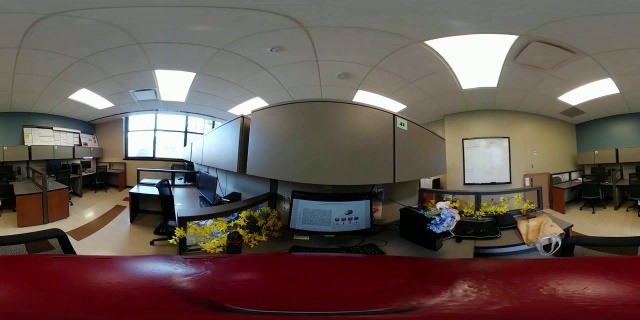

In [285]:
im = Image.open("/home/keshav/data/finalEgok360/images/Desk_work/Desk_work/0547/0.jpg")
imnp = np.array(im)
Timnp = trans.ToTensor()(im).unsqueeze(0)
im

In [286]:
imnp.shape

(320, 640, 3)

In [326]:
from matplotlib import cm
getcolors = lambda n: cm.get_cmap('plasma', n).colors
from tqdm import tqdm

def get_uv_center(u_size=4, v_size=4):
    v = np.linspace(90, -90, u_size)
    u = np.linspace(-180, 180, v_size)
    vdiff = int(abs(v[0] - v[1]))
    udiff = int(abs(u[0] - u[1]))
    mesh = np.stack(np.meshgrid(v, u), -1).reshape(-1, 2)
    return mesh, udiff, vdiff

def applyProjection(img_dim = (320,640,3),
                    gridu=4,
                    gridv=4,
                    pad=4,
                    sample_factor=10):
    uvCenter, udiff, vdiff = get_uv_center(gridu, gridv)
    colors = [c[:-1] for c in getcolors(gridu * gridv).tolist()]
    h_fov = udiff + pad * 2
    v_fov = vdiff + pad
    scale_hw = (v_fov * sample_factor, h_fov * sample_factor)
    fovlist = []
    for i, (v, u) in tqdm(enumerate(uvCenter)):
        _, idx = e2p(e_img=np.random.rand(*img_dim).astype(np.uint8),
                     h_fov=h_fov,
                     v_fov=v_fov,
                     u_deg=u,
                     v_deg=v,
                     out_hw=scale_hw,
                     in_rot_deg=180,
                     mode='bilinear')
        fovlist.append(idx)

    def morphNNFunc(nn_func=None, e_imgs=None):
        nn_func = nn_func if nn_func else lambda x,i:np.array(colors[i]).reshape(1,3)*255
        for j,e_img in enumerate(e_imgs):
            for i, idx in tqdm(enumerate(fovlist)):
                mask = tuple(idx.astype(np.long).reshape(-1,2).T)
                e_img[mask] = nn_func(e_img[mask],i)
            e_imgs[j] = e_img
        return e_imgs
    return morphNNFunc

In [327]:
morpher = applyProjection()

16it [00:04,  3.62it/s]


In [328]:
# imnps = [imnp,]

In [331]:
out = morpher(nn_func = None, e_imgs = [imnp,]*20)

16it [00:00, 30.69it/s]
16it [00:00, 33.72it/s]
16it [00:00, 33.93it/s]
16it [00:00, 34.67it/s]
16it [00:00, 42.28it/s]
16it [00:00, 42.16it/s]
16it [00:00, 42.70it/s]
16it [00:00, 42.36it/s]
16it [00:00, 41.47it/s]
16it [00:00, 42.25it/s]
16it [00:00, 42.35it/s]
16it [00:00, 42.49it/s]
16it [00:00, 42.08it/s]
16it [00:00, 42.06it/s]
16it [00:00, 41.17it/s]
16it [00:00, 41.79it/s]
16it [00:00, 40.93it/s]
16it [00:00, 42.13it/s]
16it [00:00, 41.31it/s]
16it [00:00, 41.38it/s]


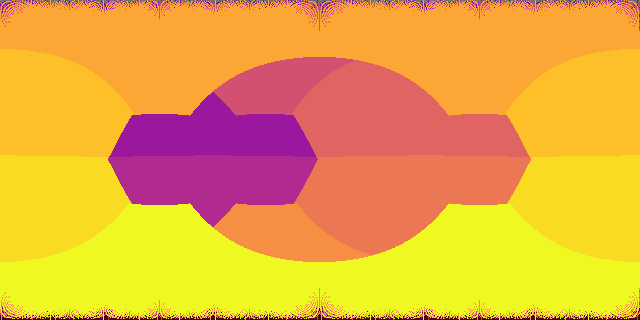

In [335]:
Image.fromarray(out[3])

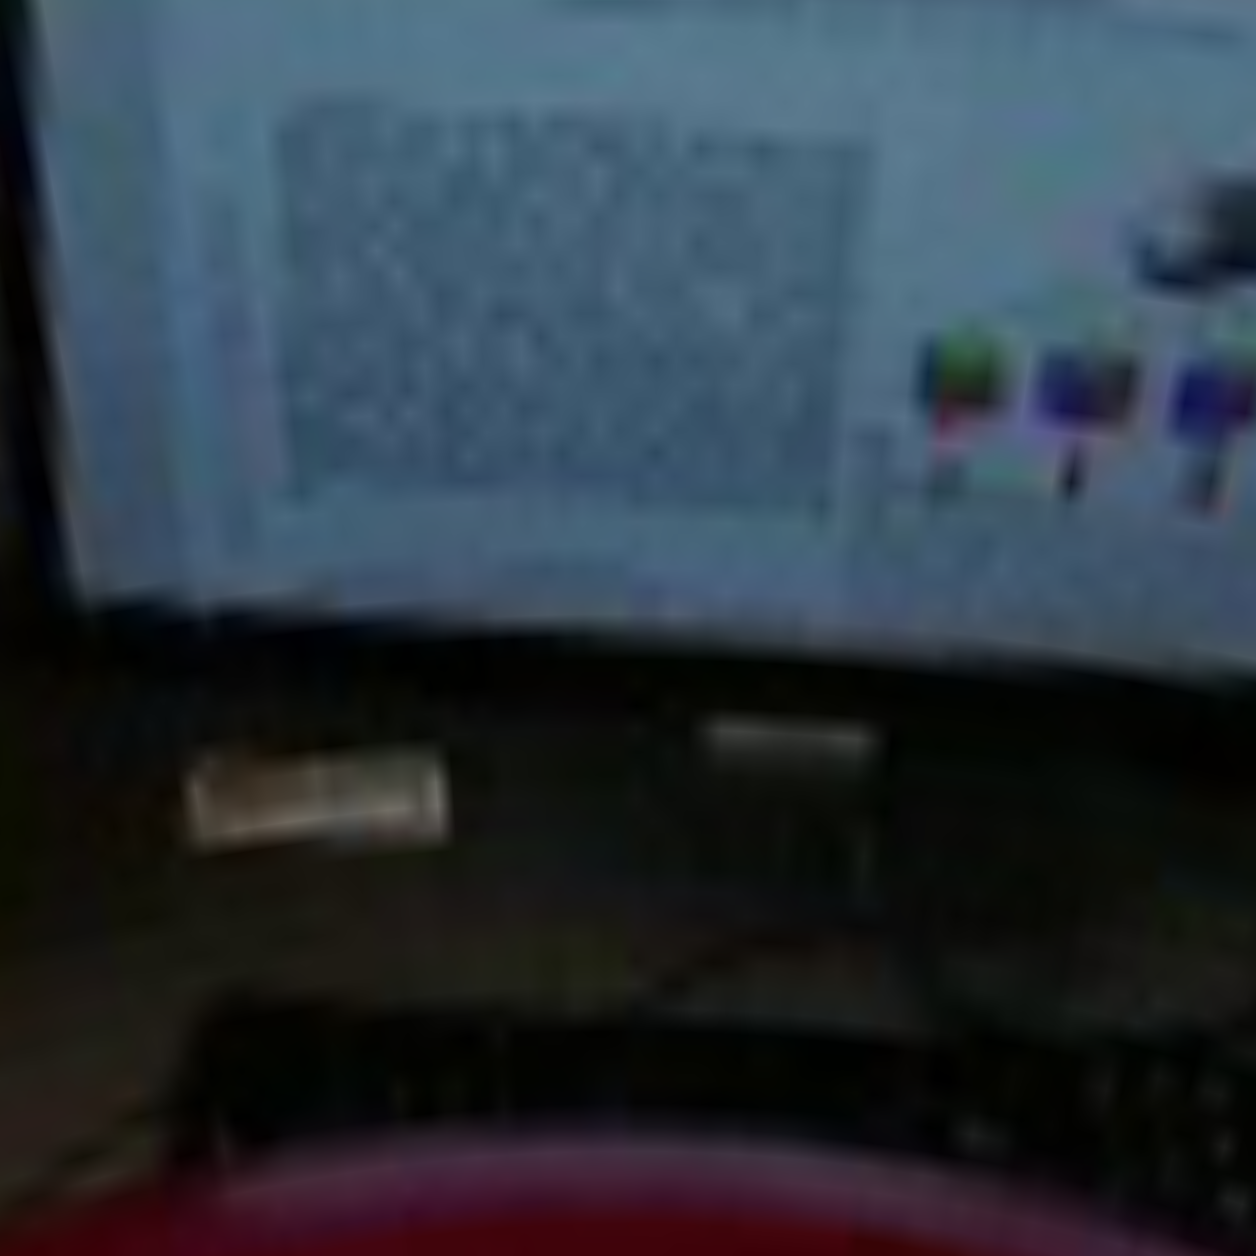

In [207]:
# e_img, h_fov, v_fov, u_deg, v_deg, out_hw, in_rot_deg=0, mode='bilinear'
nIMG,nUV = e2p(e_img = imnp, 
                    h_fov = 30, 
                    v_fov = 30, 
                    u_deg = 0, 
                    v_deg = -40, 
                    out_hw = (1256,1256), 
                    in_rot_deg = 0, 
                    mode = 'bilinear')
Image.fromarray(nIMG)

In [213]:
idXUV = nUV.astype(np.long)[...,::-1]
# idXUV.shape


In [214]:
# empty = np.empty_like(idxUV)
# empty[:,:,0] = idXUV[:,:,1]
# empty[:,:,1] = idXUV[:,:,0]

In [215]:
idXUV[:,:,0].max()

257

In [216]:
# idXUV = idXUV.transpose(2,1,0)
# idXUV.shape

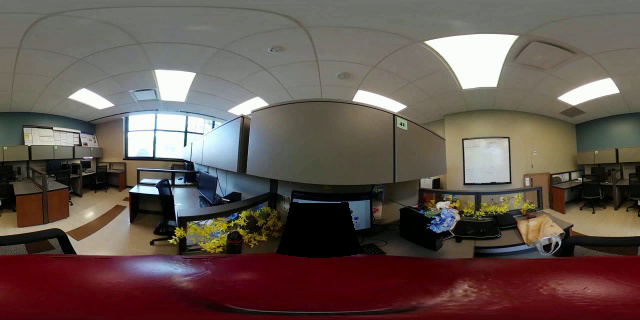

In [222]:
imnp[tuple(idXUV.reshape(-1,2).T)] = 0
Image.fromarray(imnp)

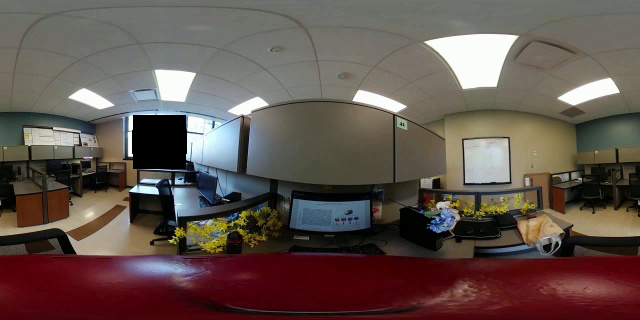

In [61]:
Image.fromarray(imnp)

In [44]:
imnp[*idXUV].shape

SyntaxError: invalid syntax (<ipython-input-44-715cab6aa14d>, line 1)

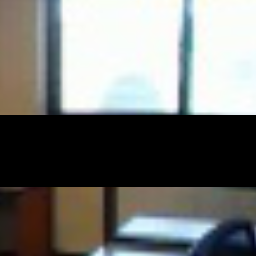

In [36]:
ima[idXUV] = 0
Image.fromarray(nIMG)

In [9]:
tIMG,tUV = Te2p(e_img = Timnp, 
            h_fov = torch.tensor([45.]), 
            v_fov = torch.tensor([640.]), 
            u_deg = torch.tensor([0.]), 
            v_deg = torch.tensor([45.]), 
            out_hw = (256,256),
            in_rot_deg = torch.tensor([180.]),
            mode = 'bilinear')

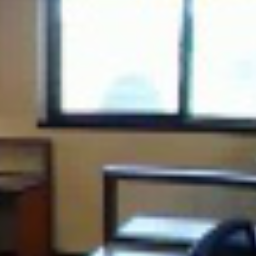

In [10]:
Image.fromarray(nIMG)

In [17]:
tUV.max()

tensor(1.4835, dtype=torch.float64)

In [198]:
tUV = tUV * 180/torch.pi

In [199]:
tUV.shape

torch.Size([256, 256, 2])

In [200]:
mid = torch.tensor([180,90.]).reshape(1,1,2)
tUV = (tUV)/mid

In [201]:
tUV.shape

torch.Size([256, 256, 2])

In [202]:
tUV.min()

tensor(-0.4147, dtype=torch.float64)

In [203]:
tUV.shape

torch.Size([256, 256, 2])

In [204]:
tUV.shape

torch.Size([256, 256, 2])

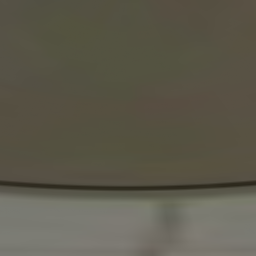

In [205]:
tt = torch.nn.functional.grid_sample(input= tIMG,grid = tUV.unsqueeze(0).float(), align_corners=True)[0]
trans.ToPILImage()(tt)

In [206]:
# torch.nn.functional.affine_grid?

In [74]:
np.stack(np.meshgrid([np.linspace(90,-90,4),np.linspace(-180,180,3)]))

array([[array([ 90.,  30., -30., -90.]), array([-180.,    0.,  180.])]],
      dtype=object)

In [91]:
y = np.linspace(90,-90,4)
x = np.linspace(-180,180,4)
mesh = np.stack(np.meshgrid(y,x),-1).reshape(-1,2)
mesh

array([[  90., -180.],
       [  30., -180.],
       [ -30., -180.],
       [ -90., -180.],
       [  90.,  -60.],
       [  30.,  -60.],
       [ -30.,  -60.],
       [ -90.,  -60.],
       [  90.,   60.],
       [  30.,   60.],
       [ -30.,   60.],
       [ -90.,   60.],
       [  90.,  180.],
       [  30.,  180.],
       [ -30.,  180.],
       [ -90.,  180.]])